In [1]:
import datetime                                               #datetime conversions
import mysql.connector                                        #accessing mysql production database
from mysql.connector import errorcode                         #catching errors of mysql
import pandas as pd                                           #dataframe manipulation
from flask import Flask, jsonify                              #Web service or creating api endpoint
from statsmodels.tsa.statespace.sarimax import SARIMAX        #time series analysis model
import xlsxwriter                                             #creating excel files for management input
import statsmodels.api as sm                                  #time series analysis model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
"""
Class: CreditAppraisal
Version: 1
Purpose: This class has four step process of assigning credit to retailers with certain Pre-conditions
"""


class CreditAppraisal:
    
    #fetch data from appraisal_prospects and after applying criteria whitelist retailers
    # Criteria 1: Retailer should not be blacklisted
    # Criteria 2: if not previously whitelisted or blacklisted
    def whitelisting(self):
        return pd.read_excel("C:/Users/tahir.usman/Desktop/Lending Solution/Final/Development/Python Code/appraisal_prospect.xlsx")
   
    
    
    # classify all whitelisted retailers into four quantiles as per their rank based on:
    # R or RECENCY last transaction, F or FREQUENCY of transactions, M or MONETARY_VALUE is average transaction size,
    # T or L or DURATION of Retailer, G or WoW_GROWTH of commission earned, A or ATTRIBUTION share of retailer to total cashin 
    def segmentation(self, df):
        self.quantiles = df.quantile(q=[0.25,0.5,0.75])
        self.quantiles = self.quantiles.to_dict()
        self.segmented_rfm = df
        self.segmented_rfm['l_quartile'] = self.segmented_rfm['T'].apply(self.LFMScore, args=('T',self.quantiles,))
        self.segmented_rfm['r_quartile'] = self.segmented_rfm['R'].apply(self.LFMScore, args=('R',self.quantiles,))
        self.segmented_rfm['f_quartile'] = self.segmented_rfm['F'].apply(self.LFMScore, args=('F',self.quantiles,))
        self.segmented_rfm['m_quartile'] = self.segmented_rfm['M'].apply(self.LFMScore, args=('M',self.quantiles,))
        self.segmented_rfm['g_quartile'] = self.segmented_rfm['WoWGrowth'].apply(self.LFMScore, args=('WoWGrowth',self.quantiles,))
        self.segmented_rfm['i_quartile'] = self.segmented_rfm['ATTRIBUTION'].apply(self.LFMScore, args=('ATTRIBUTION',self.quantiles,))
        self.segmented_rfm['LRFMGDVScore'] = self.segmented_rfm.l_quartile.map(str) + self.segmented_rfm.r_quartile.map(str) + self.segmented_rfm.f_quartile.map(str) + self.segmented_rfm.m_quartile.map(str)+ self.segmented_rfm.g_quartile.map(str)+ self.segmented_rfm.i_quartile.map(str)
        self.segmented_rfm['Pure_Score'] = self.segmented_rfm[['l_quartile','r_quartile','f_quartile', 'm_quartile','g_quartile','i_quartile']].sum(axis=1)
        self.segmented_rfm['RFM_Level'] = self.segmented_rfm.apply(self.rfm_level, axis=1)
        self.segmented_rfm['RFM_Level'].value_counts()
        return self.segmented_rfm
    
    
    
    #fetch time_series from database of only whitelisted retailers and then forecast their aggregate demand of a week
    # Timeseries is calculated on past 180 days of transactional data
    # Attribution is calculated on past 90 days of transactional data
    # Public Holidays are used as EXOGENUOUS VARIABLES please note weekly off is not holiday
    # SARIMAX model is used for forecasting
    def demand_forecast(self, df):
        df.sort_index(inplace=True)
        self.train_data = df[0:len(df)-7]
        #print(len(self.train_data))
        self.test_data = df[len(df)-7:len(df)]
        #print(self.test_data.head(7))
        # AUTOREGRESSION p = 4, DIFFERENCING d = 0, MOVING AVERAGE q = 2, seasonality = 7, EXOG = PUBLIC HOLIDAYS
        # time series is not stationary that is why ADFULLER test is conduct and shifted dataset so that it becomes stationary 
        self.model=sm.tsa.statespace.SARIMAX(self.train_data['CashIn'],exog=self.train_data['IsHoliday'],order=(4, 0, 2),seasonal_order=(4,0,2,7))
        self.results=self.model.fit()
        self.train_data['Forecast'] = 0
        self.train_data = pd.concat([self.train_data, self.test_data])
        #print(len(self.test_data['IS_HOLIDAY']))
        self.train_data['Forecast'] = self.results.predict(start=len(self.train_data)-8,end=len(self.train_data)-1,exog = self.test_data['IsHoliday'],dynamic=True,infer_datetime_format=True)[:]
        self.train_data['CashIn'].plot(figsize=(16,4))
        self.train_data['Forecast'].plot()
        return self.train_data
    
    #assigning demanded credit limit by multiplying demand with attribution
    def assign_credit_limits(self,df,demand):  
        df['CREDIT_LIMIT'] = 0
        for ind in df.index:
            df['CREDIT_LIMIT'][ind]=(df['ATTRIBUTION'][ind])*demand
            #print(df['ATTRIBUTION'][ind]," ---> ", demand," ---> ", df['CREDIT_LIMIT'][ind])
        return df
        
    
    # segmentation: classified segments as per aggregated score of all 5 criterions
    def rfm_level(self,df):
        if df['Pure_Score'] >= 21:
            return 'Ambassadors'
        elif ((df['Pure_Score'] >= 18) and (df['Pure_Score'] < 21)):
            return 'Evangelists'
        elif ((df['Pure_Score'] >= 15) and (df['Pure_Score'] < 18)):
            return 'Promoters'
        elif (df['Pure_Score'] < 15):
            return 'Passives'
        else:
            return 'Require Activation'
        
    # ranking: more the better meaning 4 is the best rank
    def LFMScore(self,x,p,d):
        if x <= d[p][0.25]:
            return 1
        elif x <= d[p][0.50]:
            return 2
        elif x <= d[p][0.75]: 
            return 3
        else:
            return 4

In [3]:
#Creating EXCEL & CSV files to store Algorithm results and working
def create_excel(df):
    # Workbook() takes one, non-optional, argument
    # which is the filename that we want to create.
    workbook = xlsxwriter.Workbook('riskappetiterule.xlsx')

    # The workbook object is then used to add new
    # worksheet via the add_worksheet() method.
    worksheet = workbook.add_worksheet()
    worksheet.set_column(0,3,30)
    cell_format_heading = workbook.add_format({'bold': True, 'font_color': 'red'})
    cell_format_normal = workbook.add_format({'bold': False, 'font_color': 'black','num_format': '#,###'})
    cell_format_total = workbook.add_format({'bold': True, 'font_color': 'red','num_format': '#,###'})
    cell_format_percent = workbook.add_format({'bold': False, 'font_color': 'black','num_format': '#,##0.00'})

    # Use the worksheet object to write
    # data via the write() method.
    worksheet.write('A1', 'SEGMENT',cell_format_heading)
    worksheet.write('B1', 'DEMAND',cell_format_heading)
    worksheet.write('C1', 'THRESHOLD',cell_format_heading)
    worksheet.write('D1', 'CREDIT LIMIT',cell_format_heading)

    worksheet.write('A2', 'Ambassadors',cell_format_normal)
    worksheet.write('A3', 'Evangelists',cell_format_normal)
    worksheet.write('A4', 'Promoters',cell_format_normal)
    worksheet.write('A5', 'Passives',cell_format_normal)

    worksheet.write_number('B2', df.groupby(["RFM_Level"]).sum()['CREDIT_LIMIT'][0],cell_format_normal)
    worksheet.write_number('B3', df.groupby(["RFM_Level"]).sum()['CREDIT_LIMIT'][1],cell_format_normal)
    worksheet.write_number('B4', df.groupby(["RFM_Level"]).sum()['CREDIT_LIMIT'][3],cell_format_normal)
    worksheet.write_number('B5', df.groupby(["RFM_Level"]).sum()['CREDIT_LIMIT'][2],cell_format_normal)

    worksheet.write_number('C2', 1.00,cell_format_percent)
    worksheet.write_number('C3', 1.00,cell_format_percent)
    worksheet.write_number('C4', 1.00,cell_format_percent)
    worksheet.write_number('C5', 1.00,cell_format_percent)

    worksheet.write_formula('D2', '=B2*C2',cell_format_normal)
    worksheet.write_formula('D3', '=B3*C3',cell_format_normal)
    worksheet.write_formula('D4', '=B4*C4',cell_format_normal)
    worksheet.write_formula('D5', '=B5*C5',cell_format_normal)

    worksheet.write('A6', 'TOTAL',cell_format_heading)
    worksheet.write_formula('B6', '=SUM(B2:B5)',cell_format_total)
    worksheet.write_formula('C6', '=D6/B6',cell_format_percent)
    worksheet.write_formula('D6', '=SUM(D2:D5)',cell_format_total)

    # Finally, close the Excel file
    # via the close() method.
    workbook.close()
    

In [4]:
crx = CreditAppraisal()
df_whitelisted = crx.whitelisting()
df_whitelisted.head()

,RETAILER_ID,M,R,F,T,WoWGrowth,ATTRIBUTION,INDUSTRY,CITY
0,1012,6240.000000,4,4,66,11015.135135,0.000607,Freelancers / IT Service Providers,Lahore
1,1218,1575.000000,5,7,59,2922.000000,0.000245,Super Stores,Shahdadpur
2,1273,1112.500000,3,3,80,25.000000,0.000087,Others,Lahore
3,1386,3296.148148,9,80,81,-48.960302,0.005196,Others,Lahore
4,1387,2500.000000,6,0,0,71.525808,0.000049,Wholesalers,Lahore


In [5]:
df_segmented = crx.segmentation(df_whitelisted)
df_segmented['RFM_Level'].value_counts()

Passives       6829
Promoters      5217
Evangelists    3062
Ambassadors     188
Name: RFM_Level, dtype: int64

In [6]:
holidays = pd.read_excel("C:/Users/tahir.usman/Desktop/Lending Solution/Final/Development/Python Code/holidays2022.xlsx")
holidays.head()

,Date,Holiday
0,2022-01-03,Bank
1,2022-02-05,Kashmir
2,2022-03-23,Pakistan
3,2022-05-01,Labour
4,2022-05-03,Eid Fitr


In [7]:
def checkHoliday(x):
    if(holidays[holidays['Date']==x]).empty:
        return 0
    else:
        return 1

In [8]:
tsHol = pd.DataFrame(columns=['Date','IsHoliday'])
j=0
for i in reversed(range(1,180)):
    tsHol.loc[len(tsHol),['Date','IsHoliday']] = [(datetime.date.today() - datetime.timedelta(days=i)),checkHoliday(str((datetime.date.today() - datetime.timedelta(days=i))))]    

In [9]:
tsHol.head()

,Date,IsHoliday
0,2022-05-21,0
1,2022-05-22,0
2,2022-05-23,0
3,2022-05-24,0
4,2022-05-25,0


In [17]:
def timeseriesDS(I):
    return pd.read_excel("C:/Users/tahir.usman/Desktop/Lending Solution/Final/Development/Python Code/TSA.xlsx")


In [18]:
df_segmented.to_csv("C:/Users/tahir.usman/Desktop/Lending Solution/Final/Development/Python Code/white.csv")

In [24]:
ts_CashIn = timeseriesDS(tuple(df_segmented['RETAILER_ID'].tolist()))

In [25]:
ts_CashIn.head()

,Date,CashIn,IsHoliday
0,2021-11-25,6631825,0
1,2021-11-26,7839749,0
2,2021-11-27,4220986,0
3,2021-11-28,163554,1
4,2021-11-29,7095537,0


In [26]:
## newDF = tsHol.merge(ts_CashIn, how='left', on='Date')
newDF = ts_CashIn

In [27]:
newDF.head()

,Date,CashIn,IsHoliday
0,2021-11-25,6631825,0
1,2021-11-26,7839749,0
2,2021-11-27,4220986,0
3,2021-11-28,163554,1
4,2021-11-29,7095537,0


<AxesSubplot:>

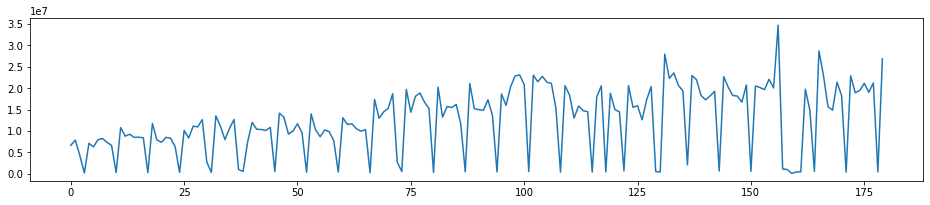

In [28]:
newDF['CashIn'].plot(figsize=(16,3))

In [29]:
newDF['IsHoliday'] = newDF['IsHoliday'].astype(int) 
newDF['Date']=pd.to_datetime(newDF['Date'])
newDF.set_index('Date', inplace=True)
newDF.dtypes

CashIn       int64
IsHoliday    int32
dtype: object

In [30]:
newDF.head()

,CashIn,IsHoliday
Date,,
2021-11-25,6631825,0
2021-11-26,7839749,0
2021-11-27,4220986,0
2021-11-28,163554,1
2021-11-29,7095537,0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarim

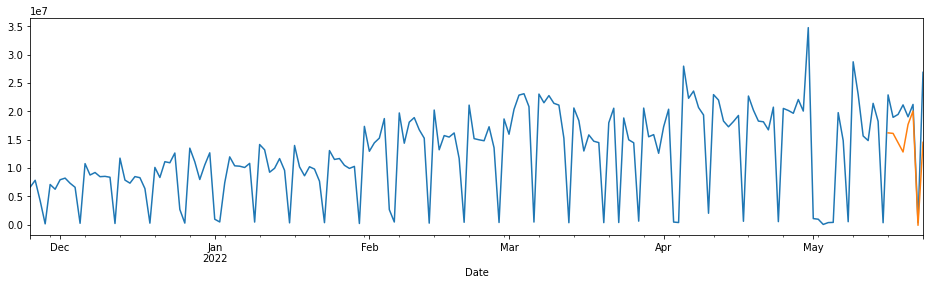

In [31]:
df_timeseries = crx.demand_forecast(newDF)

In [32]:
df_credit_limits = crx.assign_credit_limits(df_whitelisted, df_timeseries.tail(7)['Forecast'].sum())

C:\Users\TAHIR~1.USM\AppData\Local\Temp/ipykernel_15996/3830805685.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CREDIT_LIMIT'][ind]=(df['ATTRIBUTION'][ind])*demand


In [36]:
df_credit_limits.head()

,RETAILER_ID,M,R,F,T,WoWGrowth,ATTRIBUTION,INDUSTRY,CITY,l_quartile,r_quartile,f_quartile,m_quartile,g_quartile,i_quartile,LRFMGDVScore,Pure_Score,RFM_Level,CREDIT_LIMIT
0,1012,6240.000000,4,4,66,11015.135135,0.000607,Freelancers / IT Service Providers,Lahore,2,2,1,4,4,2,221442,15,Promoters,57991.413431
1,1218,1575.000000,5,7,59,2922.000000,0.000245,Super Stores,Shahdadpur,1,3,1,2,4,1,131241,12,Passives,23406.748419
2,1273,1112.500000,3,3,80,25.000000,0.000087,Others,Lahore,3,2,1,2,3,1,321231,12,Passives,8311.784133
3,1386,3296.148148,9,80,81,-48.960302,0.005196,Others,Lahore,3,3,4,3,2,4,334324,19,Evangelists,496414.141991
4,1387,2500.000000,6,0,0,71.525808,0.000049,Wholesalers,Lahore,1,3,1,3,3,1,131331,12,Passives,4681.349684


In [33]:
from werkzeug.wrappers import Request, Response
from flask import Flask

app = Flask(__name__)

@app.route("/")
def credit_appraisal_process():
    crx = CreditAppraisal()

    # STEP 1: Whitelisting of retailers
    df_whitelisted = crx.whitelisting()
    print(len(df_whitelisted))
    df_whitelisted["TOTALCASHIN"]=df_whitelisted["MONETARY_VALUE"]*(df_whitelisted["FREQUENCY"]+1)
    df_whitelisted["ATTRIBUTION"] = (df_whitelisted["TOTALCASHIN"]/df_whitelisted["TOTALCASHIN"].sum())

    # STEP 2: Segmentation of retailers (4 segments Ambassadors-TOP, Evangelists-2nd, Promoters-3rd & Passives-last)
    df_segmented = crx.segmentation(df_whitelisted)

    # STEP 3: weekly demand forecasting for aggregate cashin of whitelisted retailers only
    df_timeseries = crx.demand_forecast()

    # STEP 4: assign default credit limits as per their quarterly attribution on total cashin
    df_credit_limits = crx.assign_credit_limits(df_whitelisted, df_timeseries.tail(7)['Forecast'].sum())

    # STEP 5: Manual Step of entering Risk Appetite Rule as per segments in excel sheet to be download after algo run
    create_excel(df_credit_limits)
    
    return Response(
        df_credit_limits.to_csv(),
        mimetype="text/csv",
        headers={"Content-disposition":"attachment; filename=credit_score_limit.csv"})

if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 8080, app)

 * Running on http://localhost:8080/ (Press CTRL+C to quit)
[2022-11-16 19:49:06,704] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "C:\Users\tahir.usman\AppData\Roaming\Python\Python39\site-packages\pandas\core\indexes\base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'MONETARY_VALUE'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C

15296
